In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams

# Gets the box score of every single game (NBA + WNBA + others: nba.com doesn't seperate the leagues) 
# from 2014-2021 into a dataframe.
all_games_finder = leaguegamefinder.LeagueGameFinder()
all_games = all_games_finder.get_data_frames()[0]

# Creates empty dataframe with the same column names passed in from the dataframe containing all the games.
games = pd.DataFrame(all_games)

games.columns
games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22021,1610612737,ATL,Atlanta Hawks,0022100215,2021-11-17,ATL vs. BOS,W,240,110,...,0.833,6,34,40,28,9,4,11,17,11.0
1,22021,1610612751,BKN,Brooklyn Nets,0022100216,2021-11-17,BKN vs. CLE,W,239,109,...,0.840,8,39,47,29,7,3,11,20,10.0
2,22021,1610612739,CLE,Cleveland Cavaliers,0022100216,2021-11-17,CLE @ BKN,L,240,99,...,0.857,12,38,50,20,9,1,13,17,-10.0
3,22021,1610612752,NYK,New York Knicks,0022100218,2021-11-17,NYK vs. ORL,L,241,98,...,0.667,11,34,45,25,5,7,18,20,-6.0
4,22021,1610612753,ORL,Orlando Magic,0022100218,2021-11-17,ORL @ NYK,W,241,104,...,0.833,14,37,51,20,7,3,12,19,6.0


In [8]:
#This assumes Min is minutes played for each team
#sort the columns to pair each game with the two teams\
#!!!DONT RUN THIS BLOCK MORE THAN ONCE!!!
games = games.sort_values(by=['GAME_ID'])

gamesteam1 = games[games.index % 2 == 0]
gamesteam2 = games[games.index % 2 == 1]

gamesteam1 = gamesteam1.reset_index(drop=True)
gamesteam2 = gamesteam2.reset_index(drop=True)

games = gamesteam1.join(gamesteam2, rsuffix='_other')
print(games.columns)

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS',
       'SEASON_ID_other', 'TEAM_ID_other', 'TEAM_ABBREVIATION_other',
       'TEAM_NAME_other', 'GAME_ID_other', 'GAME_DATE_other', 'MATCHUP_other',
       'WL_other', 'MIN_other', 'PTS_other', 'FGM_other', 'FGA_other',
       'FG_PCT_other', 'FG3M_other', 'FG3A_other', 'FG3_PCT_other',
       'FTM_other', 'FTA_other', 'FT_PCT_other', 'OREB_other', 'DREB_other',
       'REB_other', 'AST_other', 'STL_other', 'BLK_other', 'TOV_other',
       'PF_other', 'PLUS_MINUS_other'],
      dtype='object')


In [9]:
#Things to drop later:
#team ID, not relevant and good teams might be identified by this => more bias
#Ironically, block percentage only really correlates to total blocks (maybe not, bc there's a few blocks that also correlate either negatively or positively to blkp)
#Maybe freethrough percent? It correlates to a few other things so I'm not sure If we should really. 
games.drop(columns=['SEASON_ID_other', 'GAME_DATE_other']) #irrelevant and basically an exact duplicate of that in the first column.

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT_other,OREB_other,DREB_other,REB_other,AST_other,STL_other,BLK_other,TOV_other,PF_other,PLUS_MINUS_other
0,12015,1610612743,DEN,Denver Nuggets,0011500001,2015-10-02,DEN @ LAC,L,240,96,...,0.769,9,30,39,22,12,6,13,15,7.0
1,12015,1610612754,IND,Indiana Pacers,0011500003,2015-10-03,IND vs. NOP,L,241,105,...,0.842,12,33,45,22,11,3,12,30,-6.0
2,12015,1610612740,NOP,New Orleans Pelicans,0011500003,2015-10-03,NOP @ IND,W,242,110,...,0.743,7,34,41,30,7,2,13,15,6.0
3,12015,1610612762,UTA,Utah Jazz,0011500004,2015-10-04,UTA @ LAL,W,240,90,...,0.619,14,34,48,11,8,6,13,31,-19.0
4,12015,1610612761,TOR,Toronto Raptors,0011500005,2015-10-04,TOR vs. LAC,W,241,93,...,0.839,7,45,52,13,7,1,16,19,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,52021,1612709930,GLI,G League Ignite,2052100057,2021-11-17,GLI @ SBL,W,238,115,...,0.625,13,28,41,20,14,2,11,18,-14.6
14996,72021,1612709911,IWA,Iowa Wolves,2072100001,2021-10-29,IWA vs. GLI,W,241,98,...,0.611,12,36,48,20,7,3,23,16,-9.0
14997,72021,1612709904,SXF,Sioux Falls Skyforce,2072100002,2021-10-31,SXF vs. GLI,W,240,104,...,0.722,7,38,45,23,8,5,27,17,-14.0
14998,32019,1610616833,GNS,Team Giannis,2531900001,2020-01-23,GNS vs. LBN,L,190,139,...,0.357,14,28,42,15,14,1,14,18,-19.6


In [10]:
games["BLK%"] = 100 * (games["BLK"] * (games["MIN"]/5))/ (games["MIN"] * (games["FGA_other"] - games["FG3A_other"])) 

#Turnover Percentage (TOV)             | TOV / (FGA + 0.44 * FTA + TOV)     TOV = turnovers
games["TOV%"] = games["TOV"] / (games["FGA"] + 0.44*games["FTA"] + games["TOV"])

#Offensive Rebound Percentage (ORB)    | ORB / (ORB + Opp DRB)              Opp = oppenent
games["ORB%"] = games["OREB"] / (games["OREB"] + games["DREB_other"])

#Defensive Rebound Percentage (DRB)    | DRB / (Opp ORB + DRB)              Opp = oppenent
games["DREB%"] = games["DREB"] / (games["OREB_other"] + games["DREB"])

#(POSS)
# need to get the bloody parenthesis correctly done!
#games["POSS"] = 0.5*((games["FGA"] + 0.4*games["FTA"] - 1.07*(games["OREB"]/(games["OREB"] + games["OREB_other"])) * (games["FGA"] - games["FGM"]) + games["TOV"]) + games["FGA_other"] + 0.4*games["FTA_other"] - 1.07 * (games["OREB_other"] / (games["OREB_other"] + games["DREB"])) * (games["FGA_other"] - games["FGM_other]) + games["TOV_other"]))

# simpler POSS
games["POSS"] = 0.96*((games["FGA"]) + games["TOV"] + 0.44*games["FTA"] - games["OREB"])
# used for PACE; probably wrong
games["POSS_other"] = 0.96*((games["FGA_other"]) + games["TOV_other"] + 0.44*games["FTA_other"] - games["OREB_other"])

#STLP
games["STL%"] = 100 * (games["STL"] * (games["MIN"]/5))/ (games["MIN"] * games["POSS"]) #need POSS feature

#FTR
games["FTR"] = games["FTM"] / games["FGA"]

#TS (you'll need to calculate TSA as well)
games["TSA"] = games["FGA"] + 0.44*games["FTA"]
games["TS"] = games["PTS"]/(2*games["TSA"])

#ASTR
games["ASTR"] = 100*games["AST"]/ (((games["MIN"]/(games["MIN"]/5)) * games["FGM"]) - games["FGM"])

#TRB
games["TRB%"] = 100*(games["REB"] * (games["REB"]/5))/(games["MIN"] * (games["REB"] + games["REB_other"]))

#PACE
games["PACE"] = 48*((games["POSS"] + games["POSS_other"])/(2*(games["MIN"]/5)))

#ORTG
games["ORTG"] = 100*(games["PTS"]/games["POSS"])

#DRTG
games["DRTG"] = 100*(games["PTS_other"]/games["POSS"])

#PER



print(games.columns)
games.head(10)

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS',
       'SEASON_ID_other', 'TEAM_ID_other', 'TEAM_ABBREVIATION_other',
       'TEAM_NAME_other', 'GAME_ID_other', 'GAME_DATE_other', 'MATCHUP_other',
       'WL_other', 'MIN_other', 'PTS_other', 'FGM_other', 'FGA_other',
       'FG_PCT_other', 'FG3M_other', 'FG3A_other', 'FG3_PCT_other',
       'FTM_other', 'FTA_other', 'FT_PCT_other', 'OREB_other', 'DREB_other',
       'REB_other', 'AST_other', 'STL_other', 'BLK_other', 'TOV_other',
       'PF_other', 'PLUS_MINUS_other', 'BLK%', 'TOV%', 'ORB%', 'DREB%', 'POSS',
       'POSS_other', 'STL%', 'FTR', 'TSA', 'TS', 'ASTR', 'TRB%', 'PACE',
       'ORTG', 'DRTG'],
      dtype='object')


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,POSS_other,STL%,FTR,TSA,TS,ASTR,TRB%,PACE,ORTG,DRTG
0,12015,1610612743,DEN,Denver Nuggets,0011500001,2015-10-02,DEN @ LAC,L,240,96,...,102.1824,1.789122,0.172414,95.80,0.501044,10.810811,2.820313,101.395200,95.419847,102.377545
1,12015,1610612754,IND,Indiana Pacers,0011500003,2015-10-03,IND vs. NOP,L,241,105,...,93.4656,1.953613,0.206522,105.64,0.496971,13.815789,2.981347,97.513693,102.564704,97.680670
2,12015,1610612740,NOP,New Orleans Pelicans,0011500003,2015-10-03,NOP @ IND,W,242,110,...,92.5440,1.684939,0.242718,119.28,0.461100,10.810811,2.604167,98.862545,102.968488,99.224179
3,12015,1610612762,UTA,Utah Jazz,0011500004,2015-10-04,UTA @ LAL,W,240,90,...,94.3104,1.950687,0.465753,94.12,0.478113,18.518519,2.777778,93.292800,97.534332,76.943751
4,12015,1610612761,TOR,Toronto Raptors,0011500005,2015-10-04,TOR vs. LAC,W,241,93,...,92.7744,2.529340,0.397260,88.84,0.523413,8.870968,1.912033,93.441062,98.011938,94.850263
5,12015,1610612746,LAC,LA Clippers,0011500005,2015-10-04,LAC @ TOR,L,240,73,...,91.0080,1.265182,0.197183,79.80,0.457393,14.814815,1.120370,92.928000,76.965250,81.182524
6,12015,1610612757,POR,Portland Trail Blazers,0011500007,2015-10-05,POR vs. SAC,L,266,105,...,107.8272,2.082576,0.111111,106.04,0.495096,14.285714,1.993218,96.300271,99.395674,103.182176
7,12015,12321,FEN,Istanbul Fenerbahce Sports Club,0011500008,2015-10-05,FEN @ BKN,W,240,101,...,87.6672,1.586525,0.210526,83.92,0.601764,17.567568,1.666667,87.955200,114.456411,108.790252
8,12015,1610612761,TOR,Toronto Raptors,0011500009,2015-10-05,TOR @ GSW,L,240,87,...,89.8176,2.213486,0.223529,95.12,0.457317,11.718750,2.258824,90.086400,96.286655,105.140601
9,12015,1610612764,WAS,Washington Wizards,0011500011,2015-10-06,WAS vs. PHI,W,240,129,...,102.4512,1.882303,0.187500,105.68,0.610333,18.750000,2.000906,104.352000,121.408565,110.114745


In [11]:
# code below updates the games.csv with the new features added
# and saves it to games_updated.cs

games_csv = games
games_csv.to_csv("games_updated.csv")

<AxesSubplot:>

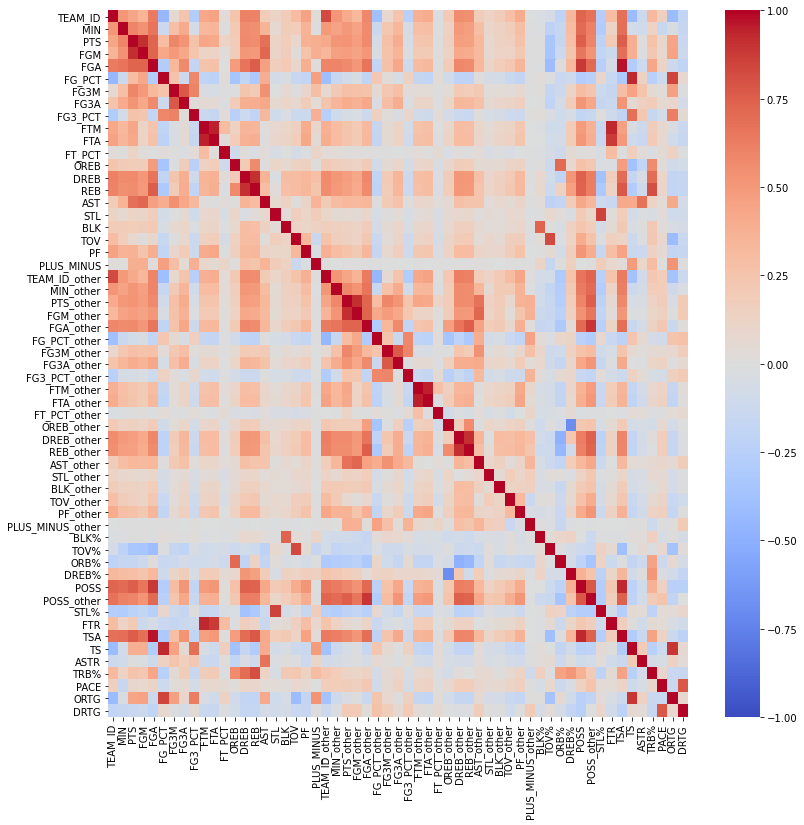

In [12]:
#Data Visualizaiton
plt.figure(figsize=(13,13))
sns.heatmap(games.corr(),cmap='coolwarm',vmin=-1)

In [ ]:
# ~ TO-DO: 
#  > simple statistics for each feature; mean, median, nth quartile, ...
#  > simple histogram; just to show basic statistics
#  > cleanup, normalize data (???)
#  > udpate document report